In [1]:
# export XLA_FLAGS=--xla_gpu_force_compilation_parallelism=1
import jax
from jax.scipy.sparse.linalg import cg
import jax.numpy as jnp
from jax import random, grad, vmap, jit
import matplotlib.pyplot as plt

import natgrad.mlp as mlp
from natgrad.domains import Square
from natgrad.domains import SquareBoundary, Polygon
from natgrad.integrators import RandomIntegrator, DeterministicIntegrator
from natgrad.derivatives import laplace
from natgrad.inner import model_laplace, model_identity
from natgrad.gram import gram_factory, nat_grad_factory, nat_grad_factory_generic
from natgrad.utility import grid_line_search_factory
from natgrad.plotting import plot_func
from natgrad.linalg import sherman_morrison

jax.config.update("jax_enable_x64", True)

In [2]:
# random seed
seed = 2

# domains
interior = Square(1.) #Polygon(jnp.array([[0,0], [1,0], [0,1]])) # S
boundary = interior.boundary()

# integrators
key = random.PRNGKey(seed)

interior_integrator = RandomIntegrator(interior, key, 30)
boundary_integrator = RandomIntegrator(boundary, key, 30)
eval_integrator = RandomIntegrator(interior, key, 200)

# model
activation = lambda x : jnp.tanh(x)
layer_sizes = [2, 32, 1]
params = mlp.init_params(layer_sizes, random.PRNGKey(seed))
model = mlp.mlp(activation)
#params = mlp.init_random_features(layer_sizes, random.PRNGKey(seed))
#model = mlp.random_features_mlp
v_model = vmap(model, (None, 0))

# 
freq = 1.

# solution
@jit
def u_star(xy): return jnp.sin(freq * jnp.pi * xy[0]) * jnp.sin(freq * jnp.pi * xy[1])

# rhs
@jit
def f(xy):
    return 2. * (freq * jnp.pi)**2 * u_star(xy)

# gramians
gram_bdry = gram_factory(model = model, trafo = model_identity, integrator = boundary_integrator)
gram_laplace = gram_factory(model = model, trafo = model_laplace, integrator = interior_integrator)

@jit
def gram(params):
    return gram_laplace(params) + gram_bdry(params)

# natural gradient
nat_grad = nat_grad_factory_generic(gram, solver=lambda A, b: cg(A, b, maxiter=1000)[0])

# trick to get the signature (params, v_x) -> v_residual
_residual = lambda params: laplace(lambda x: model(params, x))
residual = lambda params, x: (_residual(params)(x) + f(x))**2.
v_residual =  jit(vmap(residual, (None, 0)))

# loss
@jit
def interior_loss(params):
    return interior_integrator(lambda x: v_residual(params, x))

@jit
def boundary_loss(params):
    boundary_integrand = lambda x: model(params, x)**2
    return boundary_integrator(vmap(boundary_integrand, (0)))

@jit
def loss(params):
    return interior_loss(params) + boundary_loss(params)

# set up grid line search
grid = jnp.linspace(0, 30, 31)
steps = 0.5**grid
ls_update = grid_line_search_factory(loss, steps)

# errors
error = lambda x: model(params, x) - u_star(x)
v_error = vmap(error, (0))
v_error_abs_grad = vmap(lambda x: jnp.dot(grad(error)(x), grad(error)(x))**0.5)

def l2_norm(f, integrator):
    return integrator(lambda x: (f(x))**2)**0.5    
   
print("Switching to ENG \n")
N = 4000
for it in range(N):
    
    # Step:  param = param - step * nat_grads
    # Step:  param = param - step * solve(gram,  grads)
    # Step:  param = param - step * cg(gram,  grads)
    #       CG: 
    # 
    grads = grad(loss)(params)
    nat_grads = nat_grad(params, grads)
    params, actual_step = ls_update(params, grads)
    
    if it % 50 == 0:    
        interior_integrator.update()
        boundary_integrator.update()
        
        gram_mat = gram(params)
        
        # errors
        l2_error = l2_norm(v_error, eval_integrator)
        h1_error = l2_error + l2_norm(v_error_abs_grad, eval_integrator)
        loss_val = loss(params)

        jnp.save(f"/home/emastr/phd/NaturalGradientTraining/data/state_{it}", {"gram": gram_mat, "params":params, "loss": loss_val, "error": l2_error})
        print(f'NG Iteration: {it} with loss: {loss_val} with error '
              f'L2: {l2_error} and error H1: {h1_error} and step: {actual_step}', end="\r")


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Switching to ENG 



(-0.002512562814070352,
 1.0025125628140703,
 -0.002512562814070352,
 1.0025125628140703)

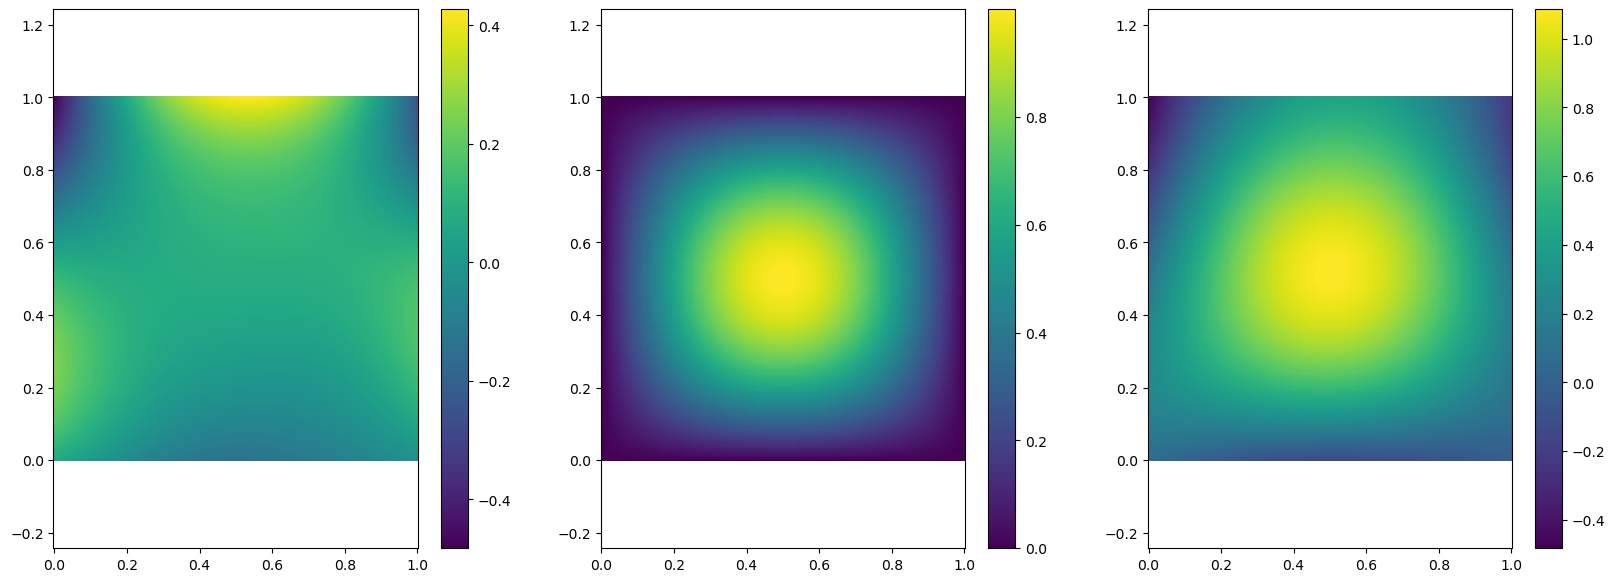

In [3]:
import matplotlib.pyplot as plt

points = interior.random_integration_points(random.PRNGKey(0), 5000)
vals = v_model(params, points)

plt.figure(figsize=(20, 7))

plt.subplot(1, 3, 1)
pmesh = plot_func(vmap(error, (0)), interior)
plt.colorbar(pmesh)
plt.axis('equal')

plt.subplot(1, 3, 2)
pmesh = plot_func(vmap(u_star, (0)), interior)
plt.colorbar(pmesh)
plt.axis('equal')

plt.subplot(1, 3, 3)
pmesh = plot_func(lambda x: v_model(params, x), interior)
plt.colorbar(pmesh)
plt.axis('equal')

[64, 32, 32, 1]


/tmp/ipykernel_123130/3079479698.py:43: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n, n, i+1)
/tmp/ipykernel_123130/3079479698.py:50: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n, n, i+1)


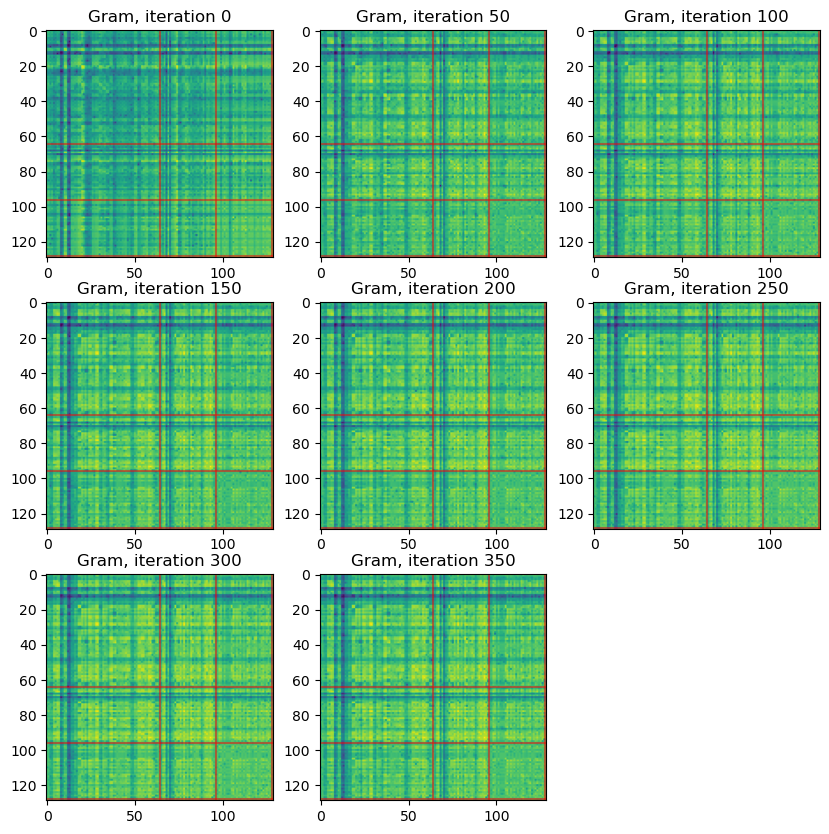

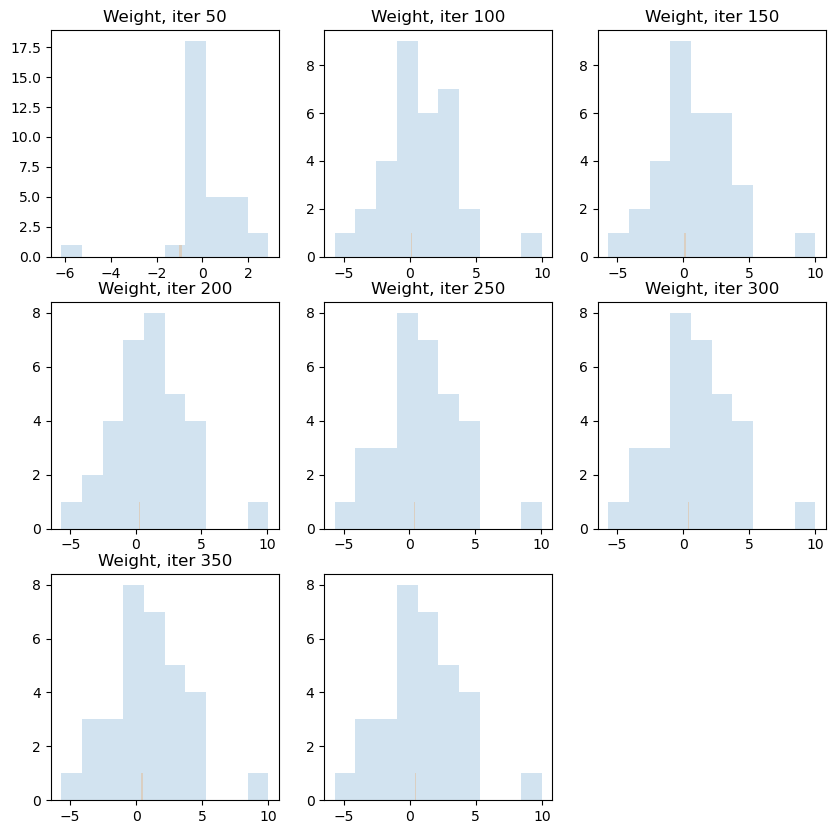

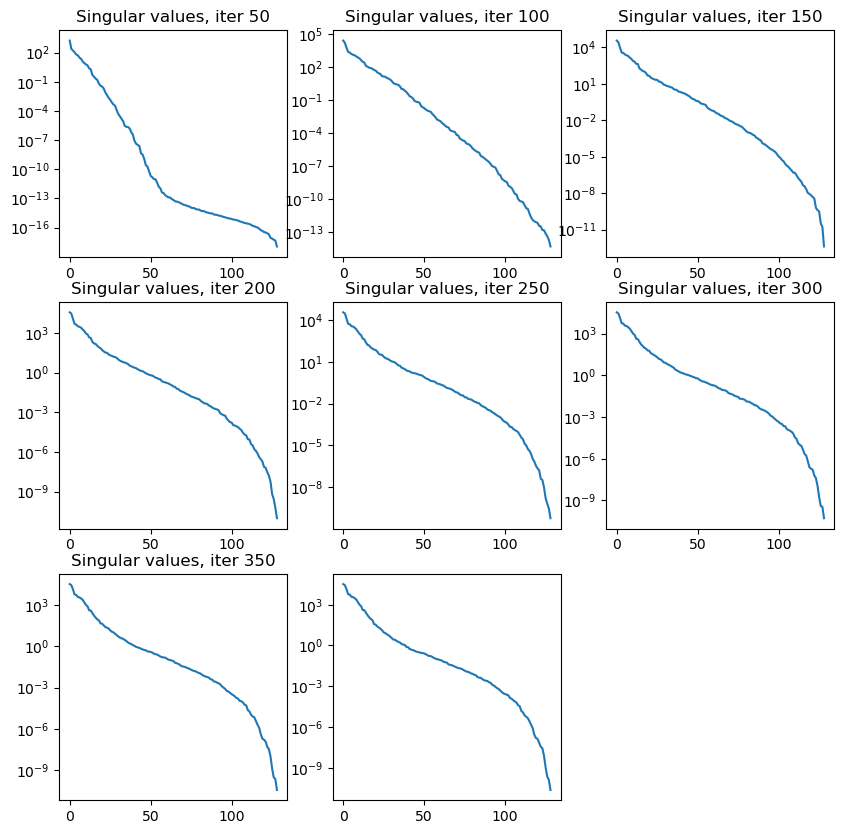

In [3]:
ids = list(range(0, 400, 50))
n = int(jnp.ceil(float(len(ids)) ** 0.5))

plt.figure(figsize=(10, 10))
plt.suptitle="Gramians"

plt.figure(figsize=(10, 10))
plt.suptitle="Gramians"

plt.figure(figsize=(10, 10))
plt.suptitle="Gramians"

par_nums = []
for p in params: par_nums = par_nums + [p[0].shape[0]*p[0].shape[1]] + [len(p[1])]
print(par_nums)
par_nums = jnp.cumsum(jnp.array(par_nums))

mat = None
for i in range(len(ids)):
    data = jnp.load(f"/home/emastr/phd/NaturalGradientTraining/data/state_{ids[i]}.npy", allow_pickle=True).item()
    if mat is None:
        mat = data["gram"]
    else:
        alf = 0.5 #(1/i) ** 0.5
        mat = (1 - alf) * mat + alf * data["gram"]
    param = data["params"]
        
        
    sing_vals = jnp.linalg.svd(mat, compute_uv=False)
    
    plt.figure(1)
    plt.subplot(n, n, i+1)
    plt.title(f"Gram, iteration {ids[i]}")
    for j in range(len(par_nums)-1):
        plt.plot([par_nums[j], par_nums[j]], [0, mat.shape[0]], 'red', alpha=.5)
        plt.plot([0, mat.shape[0]], [par_nums[j], par_nums[j]], 'red', alpha=.5)
    #plt.imshow(jnp.abs(mat))
    plt.imshow(jnp.log10(jnp.abs(mat)))
    
    
    plt.figure(2)
    plt.title(f"Weight, iter {ids[i]}")
    plt.subplot(n, n, i+1)
    for p in param:
        plt.hist(p[1].flatten(), alpha=0.2, density=False)
        
        
    plt.figure(3)
    plt.title(f"Singular values, iter {ids[i]}")
    plt.subplot(n, n, i+1)
    plt.semilogy(sing_vals)
    